### This Jupyter notebook demonstrates how to load, calculate backscatter change, mosaic, and visualize OPERA RTC-S1 data

In [1]:
# Data ETL imports
import numpy as np
import glob
import rioxarray

# GIS imports
import shapely.wkt as wkt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.warp import reproject, transform_bounds
from rasterio.crs import CRS
import folium
from folium import plugins
from rtc_utils import getbasemaps
from rasterio.warp import calculate_default_transform, Resampling
from rasterio.mask import mask
from shapely.geometry import box

# Plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Misc imports
from pathlib import Path
import sys
from datetime import datetime
from functools import partial

sys.path.append('../../')

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

##### The sample data used here is made available via OPERA's AWS S3 bucket. Users can downlaoad data from the ASF DAAC in the future and replace the below links with local paths.

In [2]:
# set event date
event_date = datetime(year=2023, month=2, day=18)

In [3]:
data_dir = 's3://opera-pst-rs-pop1/products/RTC_S1/'
filepath = Path('../data/rtc_manifest.txt')

with open(filepath, 'r') as f:
    file_list = f.readlines()

# Given a filename, parse out the time stamp and return it as a datetime object
def parse_date_time(filename):
    yyyymmdd = filename.split("/")[-1].split('_')[4][:8]
    year, month, day = [int(x) for x in [yyyymmdd[:4], yyyymmdd[4:6], yyyymmdd[6:]]]
    return datetime(year=year, month=month, day=day)

# Given a filename, return if it is before the reference date
def return_is_preevent(filename, reference_date):
    return parse_date_time(filename) < reference_date

# Given a filename, return if it is on or after the reference date
def return_is_postevent(filename, reference_date):
    return parse_date_time(filename) >= reference_date

In [4]:
# From the manifest list, separate out the pre and post event filepaths
fullPath_preEvent = sorted([x.strip() for x in file_list if return_is_preevent(x, event_date)])
fullPath_postEvent = sorted([x.strip() for x in file_list if return_is_postevent(x, event_date)])

In [5]:
fullPath_preEvent[0], fullPath_postEvent[0]

('s3://opera-pst-rs-pop1/products/RTC_S1/OPERA_L2_RTC-S1_T053-112908-IW1_20220816T083117Z_20230810T232159Z_S1A_30_v0.4',
 's3://opera-pst-rs-pop1/products/RTC_S1/OPERA_L2_RTC-S1_T053-112908-IW1_20230224T083114Z_20230810T232157Z_S1A_30_v0.4')

In [6]:
# Given the list of pre and post event paths, return the names of the VV and VH files
def return_s3_location(polarization, filepath):
     return f"{filepath}/{filepath.split('/')[-1]}_{polarization}.tif"

vv_paths_preevent = list(map(partial(return_s3_location, "VV"), fullPath_preEvent))
vv_paths_postevent = list(map(partial(return_s3_location, "VV"), fullPath_postEvent))

vh_paths_preevent = list(map(partial(return_s3_location, "VH"), fullPath_preEvent))
vh_paths_postevent = list(map(partial(return_s3_location, "VH"), fullPath_postEvent))

#### Select Subswaths from list 
We have specific burst IDs that we know cover our AOI. We filter our list to contain only these bursts

In [7]:
def filter_by_burstids(lines, burstids):
    return [line for line in lines if any([bid in line for bid in burstids])]

burstids = ['112912-IW2', '112913-IW2']

filtered_vv_list_preevent = filter_by_burstids(vv_paths_preevent, burstids)
filtered_vv_list_postevent = filter_by_burstids(vv_paths_postevent, burstids)

filtered_vh_list_preevent = filter_by_burstids(vh_paths_preevent, burstids)
filtered_vh_list_postevent = filter_by_burstids(vh_paths_postevent, burstids)

### Read raster metadata

We have now filepaths/names of bursts covering our AOI, sorted by polarization, pre- and post- event. We will now calculate the mean of these bursts which will enable landslide/change detection

### Calculate mean of RTC-S1 bursts

In [8]:
# location for saved rasters
output_path = Path("../data")
output_path.mkdir(exist_ok=True, parents=True)

In [9]:
def write_burst_mean(burst_id, burst_list, prefix, polarization):
    burst_list = [x for x in burst_list if burst_id in x] # filter list by burst_id
        
    # Open the first raster to get its properties
    with rasterio.open(burst_list[0]) as src:
        mean_profile = src.profile
        data_type = src.dtypes[0]
        shape = src.shape

    mean_array = np.zeros(shape, dtype=data_type)
    
    # Loop through each raster and accumulate pixel values
    for raster_path in burst_list:
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)
            mean_array += raster_data

    mean_array = mean_array / len(burst_list)

    # write out averaged burst
    output_file = output_path / f"{burst_id}_mean_{prefix}Event_{polarization}.tif"
    # burst_mean, burst_mean_profile = write_burst_mean([x for x in filtered_vv_list_preevent if burstids[0] in x])
    with rasterio.open(output_file, 'w', **mean_profile) as dst:
        dst.write(mean_array, 1)

    return output_file

In [10]:
# There are 2 polarizations, 2 burst IDs, and pre- and post- event lists. In all, there are 8 rasters that need to be computed and written out
# Averaging pre-event bursts
burst1_vv_preevent = write_burst_mean(burstids[0], filtered_vv_list_preevent, "pre", "VV")
burst2_vv_preevent = write_burst_mean(burstids[1], filtered_vv_list_preevent, "pre", "VV")

burst1_vh_preevent = write_burst_mean(burstids[0], filtered_vh_list_preevent, "pre", "VH")
burst2_vh_preevent = write_burst_mean(burstids[1], filtered_vh_list_preevent, "pre", "VH")

# Averaging post-event bursts
burst1_vv_postevent = write_burst_mean(burstids[0], filtered_vv_list_postevent, "post", "VV")
burst2_vv_postevent = write_burst_mean(burstids[1], filtered_vv_list_postevent, "post", "VV")

burst1_vh_postevent = write_burst_mean(burstids[0], filtered_vh_list_postevent, "post", "VH")
burst2_vh_postevent = write_burst_mean(burstids[1], filtered_vh_list_postevent, "post", "VH")

### Merge RTC-S1 bursts
As a final step, we can merge the averaged bursts to create single rasters for each of the 8 cases

In [11]:
# Merge the pre-event datasets
mosaic_preEvent_VV, transform_preEvent_VV = merge([burst1_vv_preevent, burst2_vv_preevent], nodata=np.nan, method='first')
mosaic_preEvent_VH, transform_preEvent_VH = merge([burst1_vh_preevent, burst2_vh_preevent], nodata=np.nan, method='first')

# create a sample profile to be used later to write out the merged profiles
with rasterio.open(burst1_vv_preevent) as ds:
    out_profile = ds.profile
out_profile.update(transform=transform_preEvent_VV, width=mosaic_preEvent_VV.shape[2], height=mosaic_preEvent_VV.shape[1])

# Merge the post-event datasets
mosaic_postEvent_VV, transform_postEvent_VV = merge([burst1_vv_postevent, burst2_vv_postevent], nodata=np.nan, method='first')
mosaic_postEvent_VH, transform_postEvent_VH = merge([burst1_vh_postevent, burst2_vh_postevent], nodata=np.nan, method='first')

### Convert backscatter from linear scale to decibels
With the rasters merged, we are now down to 4 rasters - 2 for each polarization, and 2 for pre and post event. We will convert these rasters to the log scale to compress the dynamic range and aid visualization

In [12]:
# Convert rasters to dB scale to help compress dynamic range
mosaic_preEvent_VV_db = 10*np.log10(mosaic_preEvent_VV)
mosaic_preEvent_VH_db = 10*np.log10(mosaic_preEvent_VH)

mosaic_postEvent_VV_db = 10*np.log10(mosaic_postEvent_VV)
mosaic_postEvent_VH_db = 10*np.log10(mosaic_postEvent_VH)

### Calculate Log Ratio Backscatter Change
The ratio of amplitudes provides an indication of the magnitude of backscatter change, which can be used to identify landslides. This is equivalent to calculating the difference between the two amplitudes in the log scale.

In [13]:
# Write out the merged datasets 
logRatio_VV = mosaic_preEvent_VV_db-mosaic_postEvent_VV_db
output_file = output_path / "logRatio_VV.tif"
with rasterio.open(output_file, 'w', **out_profile) as dst:
    dst.write(logRatio_VV)

logRatio_VH = mosaic_preEvent_VH_db-mosaic_postEvent_VH_db
output_file = output_path / "logRatio_VH.tif"
with rasterio.open(output_file, 'w', **out_profile) as dst:
    dst.write(logRatio_VH)

print("Rasters successfully merged and written to a new raster file.")

Rasters successfully merged and written to a new raster file.


### Visualize Backscatter Change


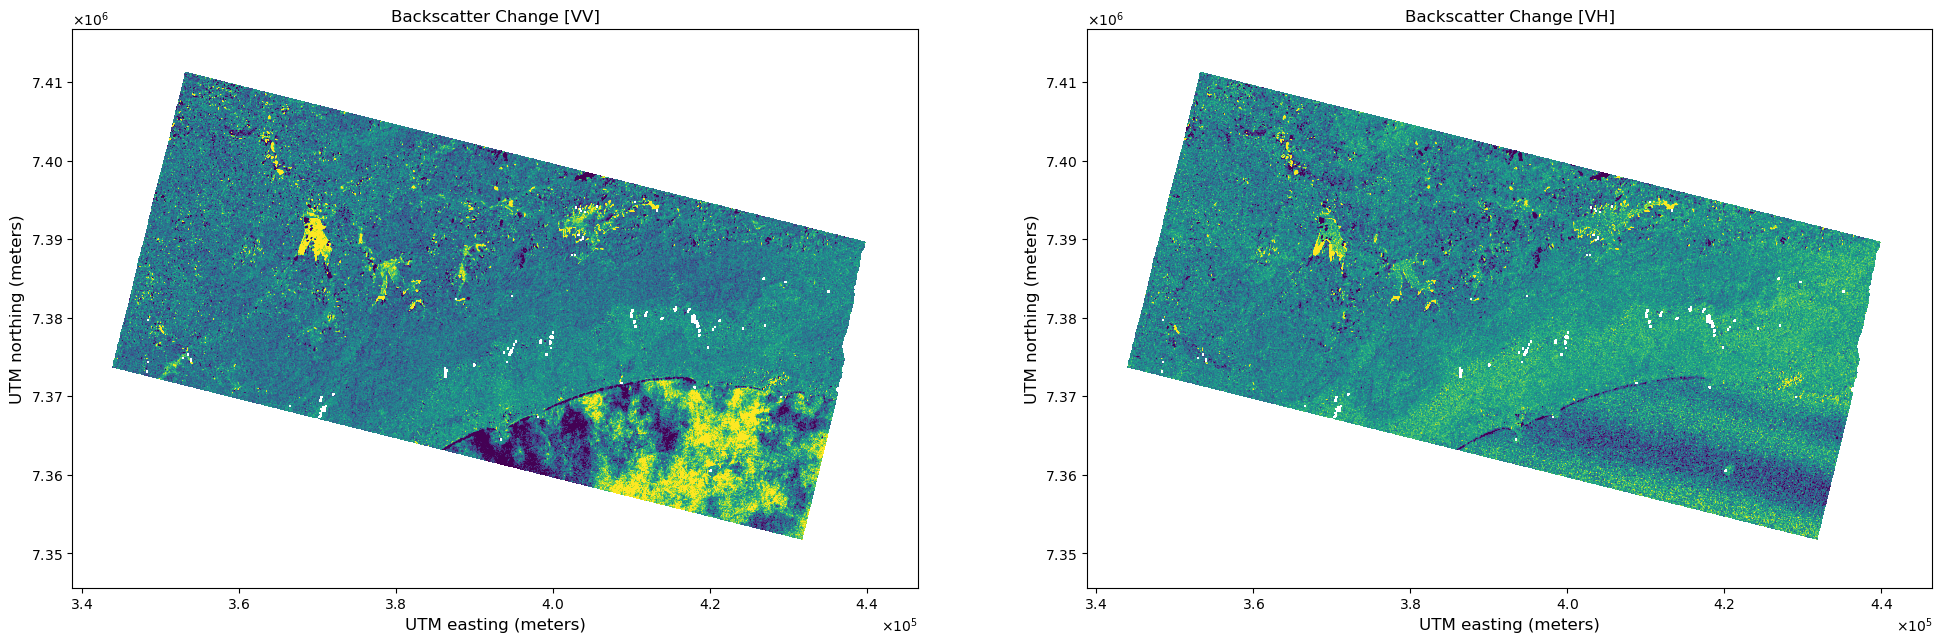

In [14]:
# visualize mosaics
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

# VV plot
show(logRatio_VV, transform=transform_postEvent_VV, ax=ax[0], vmin=-1,vmax=1)
ax[0].set_title("Backscatter Change [VV]", fontsize=12)
ax[0].set_xlabel('UTM easting (meters)',fontsize=12)
ax[0].set_ylabel('UTM northing (meters)',fontsize=12)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

# VH plot
show(logRatio_VH, transform=transform_postEvent_VV, ax=ax[1], vmin=-1,vmax=1) # ,
ax[1].set_title("Backscatter Change [VH]", fontsize=12)
ax[1].set_xlabel('UTM easting (meters)',fontsize=12)
ax[1].set_ylabel('UTM northing (meters)',fontsize=12)
ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)


### Visualize backscatter

Typically, specular reflections of radar signals on smooth surfaces result in low backscatter (dark pixels) regions as the targets reflects the signals away from the SAR satellite, while diffuse scattering from surfaces exhibiting roughness at the same scale as the radar wavelength results in more backscatter (light pixels).

Thus, targets such as open surface water and paved roads appear dark in the images, while vegetation and urban areas can appear as bright regions 

In [15]:
np.nanmin(mosaic_preEvent_VV_db[0]), np.nanmax(mosaic_preEvent_VV_db[0]), np.nanmin(mosaic_postEvent_VV_db[0]), np.nanmax(mosaic_postEvent_VV_db[0])

(-25.50974, 27.702381, -25.393326, 27.83725)

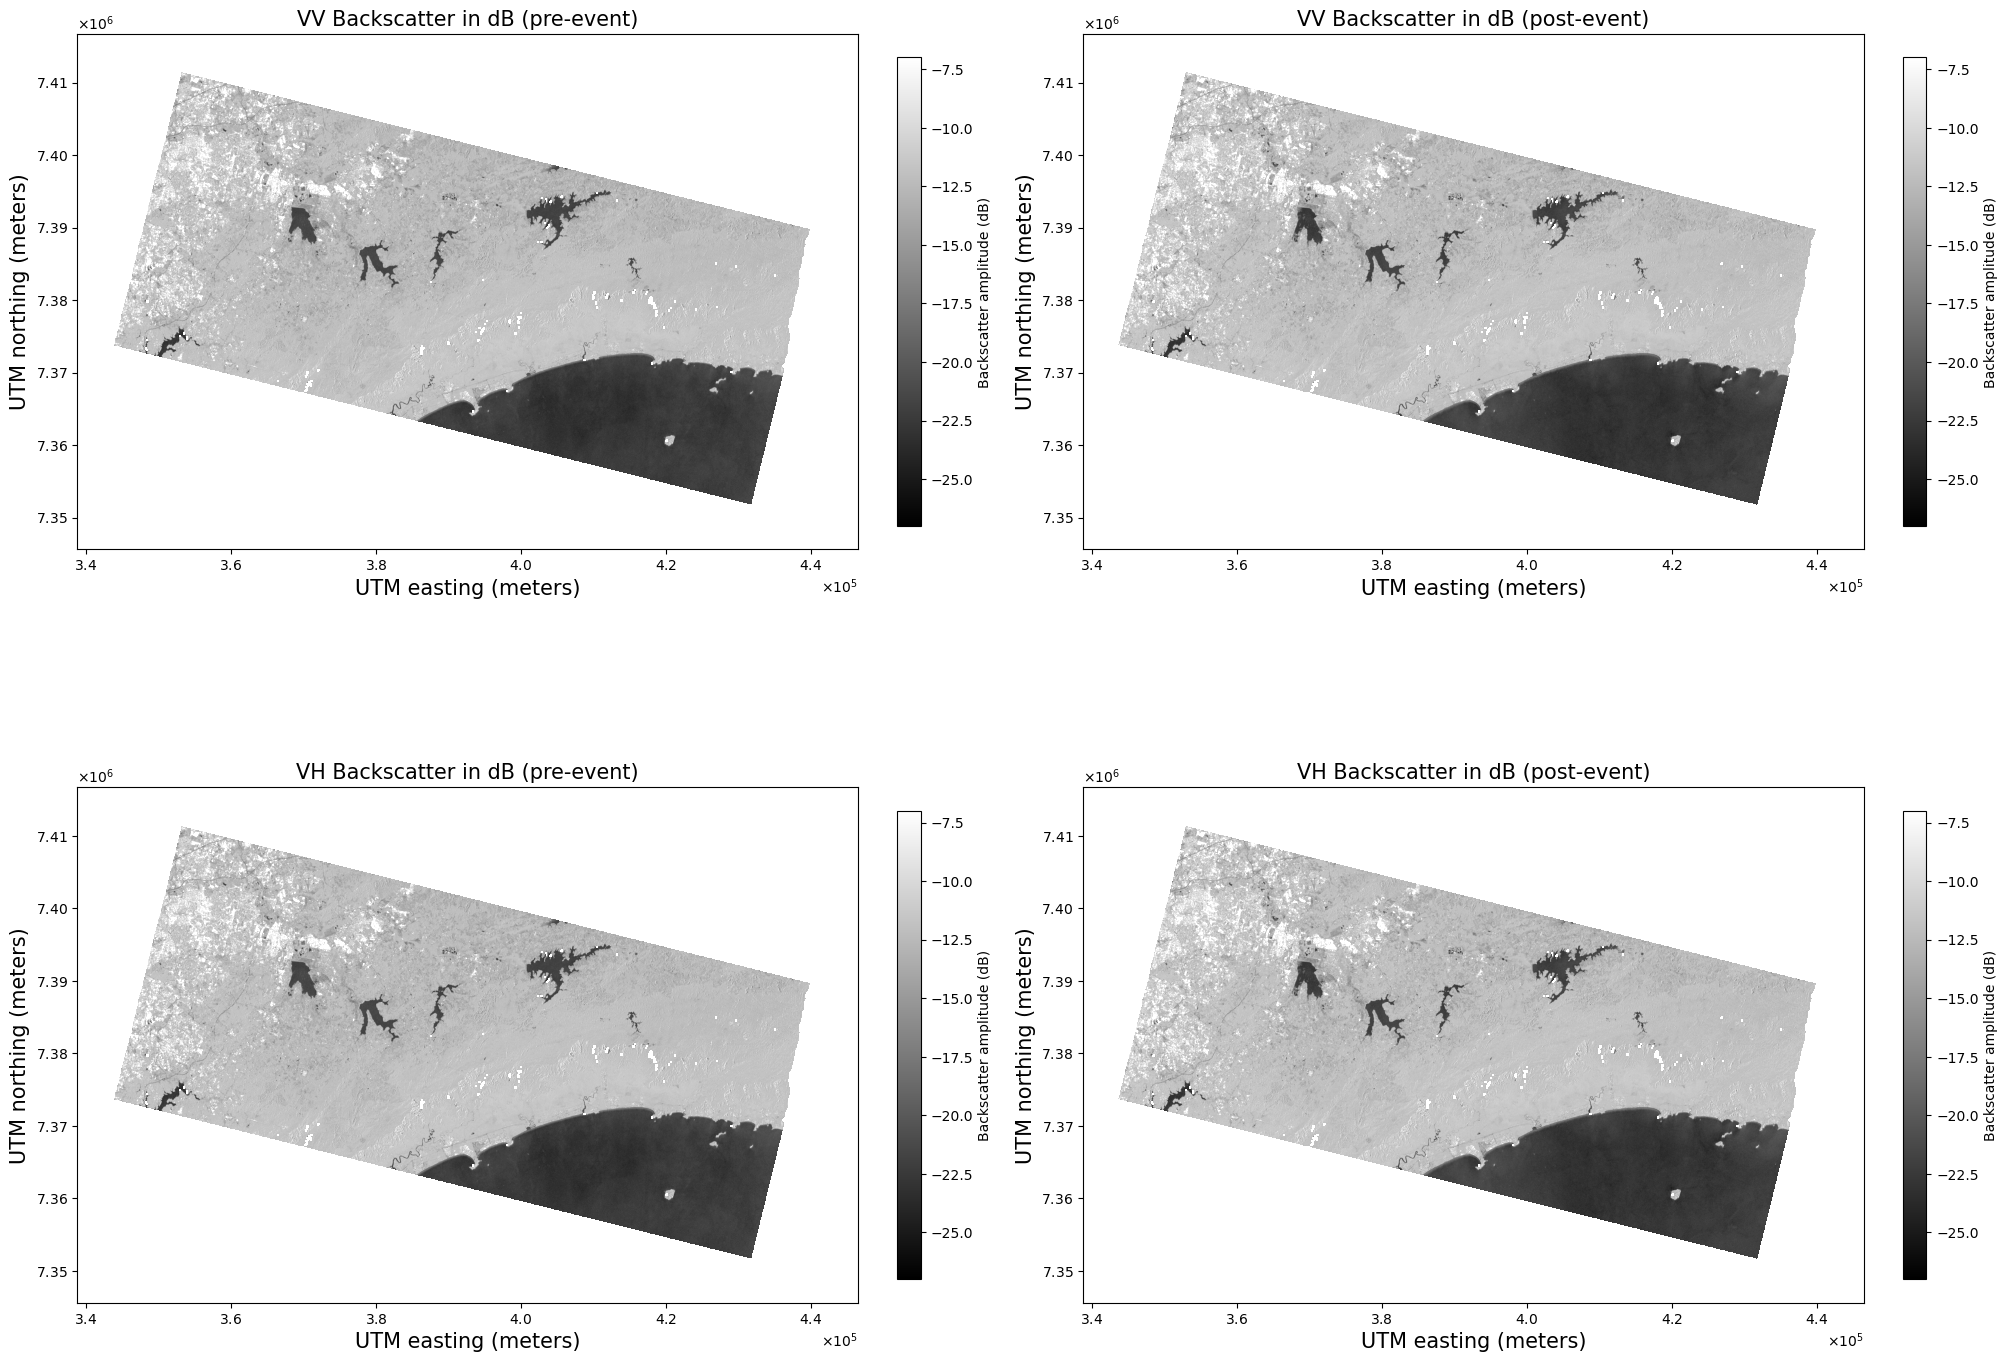

In [16]:
# visualize mosaics
fig, ax = plt.subplots(2, 2, figsize=(20, 15), layout='constrained')

# VV plots
im = ax[0, 0].imshow(mosaic_preEvent_VV_db[0], cmap='gray',vmin=-27,vmax=-7) # imshow to setup plot
# rasterio.show is preferable for visualization as it correctly sets axes extents
show(mosaic_preEvent_VV_db[0],vmin=-27,vmax=0, cmap='gray', transform=transform_preEvent_VV, ax=ax[0, 0]) 

ax[0, 0].set_title("VV Backscatter in dB (pre-event)", fontsize=15)
ax[0, 0].set_xlabel('UTM easting (meters)',fontsize=15)
ax[0, 0].set_ylabel('UTM northing (meters)',fontsize=15)
ax[0, 0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

cbar = plt.colorbar(im, ax=ax[0, 0], fraction=0.03)
cbar.set_label('Backscatter amplitude (dB)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

im = ax[0, 1].imshow(mosaic_postEvent_VV_db[0], cmap='gray',vmin=-27,vmax=-7)
show(mosaic_postEvent_VV_db[0],vmin=-27,vmax=0, cmap='gray', transform=transform_postEvent_VV, ax=ax[0, 1])

ax[0, 1].set_title("VV Backscatter in dB (post-event)", fontsize=15)
ax[0, 1].set_xlabel('UTM easting (meters)',fontsize=15)
ax[0, 1].set_ylabel('UTM northing (meters)',fontsize=15)
ax[0, 1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

cbar = plt.colorbar(im, ax=ax[0, 1], fraction=0.03)
cbar.set_label('Backscatter amplitude (dB)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

# VH plots
im = ax[1, 0].imshow(mosaic_preEvent_VH_db[0], cmap='gray',vmin=-27,vmax=-7) # imshow to setup plot
# rasterio.show is preferable for visualization as it correctly sets axes extents
show(mosaic_preEvent_VV_db[0],vmin=-27,vmax=0, cmap='gray', transform=transform_preEvent_VV, ax=ax[1, 0]) 

ax[1, 0].set_title("VH Backscatter in dB (pre-event)", fontsize=15)
ax[1, 0].set_xlabel('UTM easting (meters)',fontsize=15)
ax[1, 0].set_ylabel('UTM northing (meters)',fontsize=15)
ax[1, 0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

cbar = plt.colorbar(im, ax=ax[1, 0], fraction=0.03)
cbar.set_label('Backscatter amplitude (dB)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

im = ax[1, 1].imshow(mosaic_postEvent_VH_db[0], cmap='gray',vmin=-27,vmax=-7)
show(mosaic_postEvent_VV_db[0],vmin=-27,vmax=0, cmap='gray', transform=transform_postEvent_VV, ax=ax[1, 1])

ax[1, 1].set_title("VH Backscatter in dB (post-event)", fontsize=15)
ax[1, 1].set_xlabel('UTM easting (meters)',fontsize=15)
ax[1, 1].set_ylabel('UTM northing (meters)',fontsize=15)
ax[1, 1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

cbar = plt.colorbar(im, ax=ax[1, 1], fraction=0.03)
cbar.set_label('Backscatter amplitude (dB)', fontsize=10)
cbar.ax.tick_params(labelsize=10)


### Let us visualize the backscatter on an interactive Folium map

In [17]:
# helper function for folium visualization
def colorize(array=[], cmap='RdBu', cmin=[], cmax=[]):
    normed_data = (array - cmin) / (cmax - cmin)    
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data) 

#### Preparing arrays for Folium

In [18]:
mask_bounds = [421820.0, 7368620.0, 433490.0, 7376000.0]
mask_shape = box(*mask_bounds) # we are going to crop the raster to an area of interest
# mask_shape = world[world.name == 'Brazil'].iloc[0].geometry

# Load up VV data
input_file = output_path / "logRatio_VV.tif"
with rasterio.open(input_file) as ds:
    vv_img, transform = mask(ds, [mask_shape], nodata=np.nan)
    img_bounds = ds.bounds
    src_transform = ds.transform
    src_crs = ds.crs
mask_bounds_4326 = transform_bounds(src_crs, CRS.from_epsg(4326), *mask_bounds)
mask_shape_4326 = box(*mask_bounds_4326)

# Load up VV data
input_file = output_path / "logRatio_VH.tif"
with rasterio.open(input_file) as ds:
    vh_img, transform = mask(ds, [mask_shape], nodata=np.nan)

left, bottom, right, top = img_bounds
transform, width, height = calculate_default_transform(src_crs, CRS.from_epsg(4326), width = vv_img.shape[-1], height=vv_img.shape[-2], left=left, bottom=bottom, right=right, top=top)

vv_img_transformed = np.zeros((1, height, width))*np.nan
_ = reproject(vv_img, vv_img_transformed, src_crs = src_crs, dst_crs=CRS.from_epsg(4326), src_transform=src_transform, src_nodata=np.nan, dst_transform=transform)

vh_img_transformed = np.zeros((1, height, width))*np.nan
_ = reproject(vh_img, vh_img_transformed, src_crs = src_crs, dst_crs=CRS.from_epsg(4326), src_transform=src_transform, src_nodata=np.nan, dst_transform=transform)

In [19]:
# Let's add an ocean mask to aid with the visualization. We use a separately downloaded NASA DEM tile for this purpose
with rasterio.open('../data/s24w046.hgt') as ds:
    dem_img, dem_transform = mask(ds, [mask_shape_4326])
    dem_crs = ds.crs

dem_array = np.zeros_like(vv_img_transformed)

reproject(dem_img,
            dem_array,
            src_transform=dem_transform,
            src_crs=dem_crs,
            dst_transform=transform,
            dst_crs=CRS.from_epsg(4326),
            dst_nodata=np.nan,
            resampling=Resampling.nearest)

# We can use the fact that land will have non-zero elevation values to mask out the ocean
dem_array = np.where(dem_array[0]>0, 1, np.nan)

#### Generate Folium map


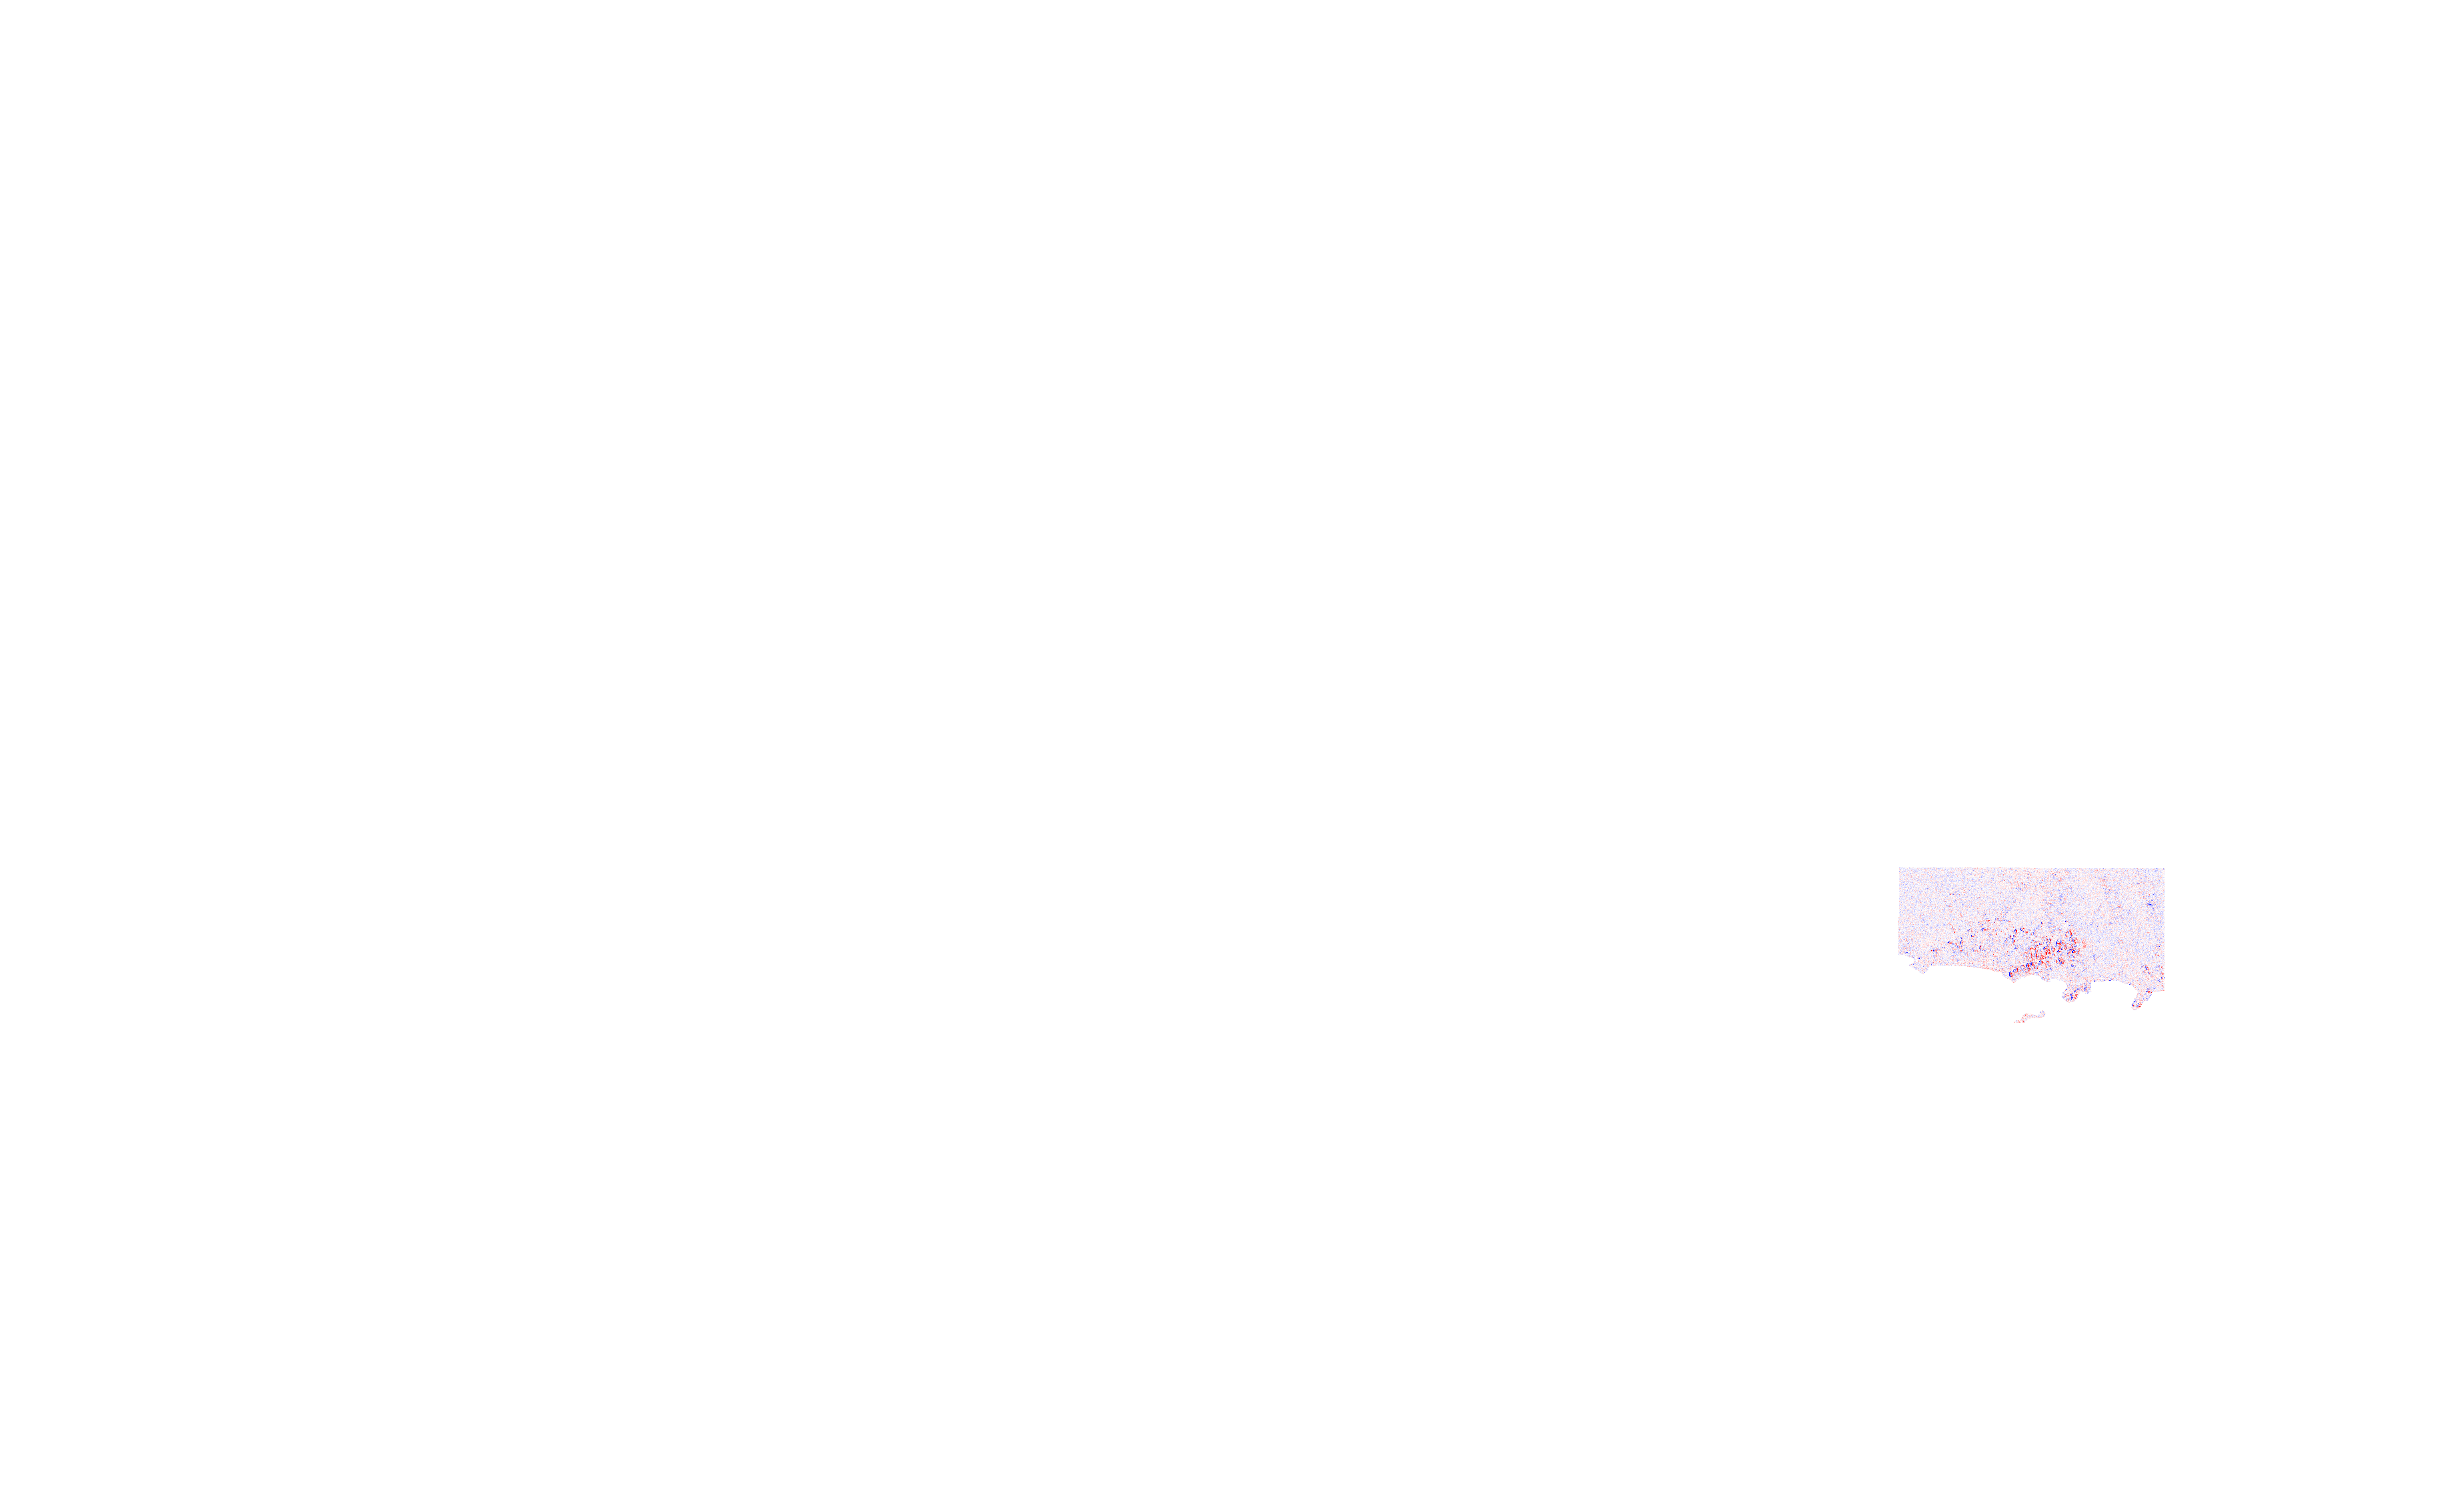
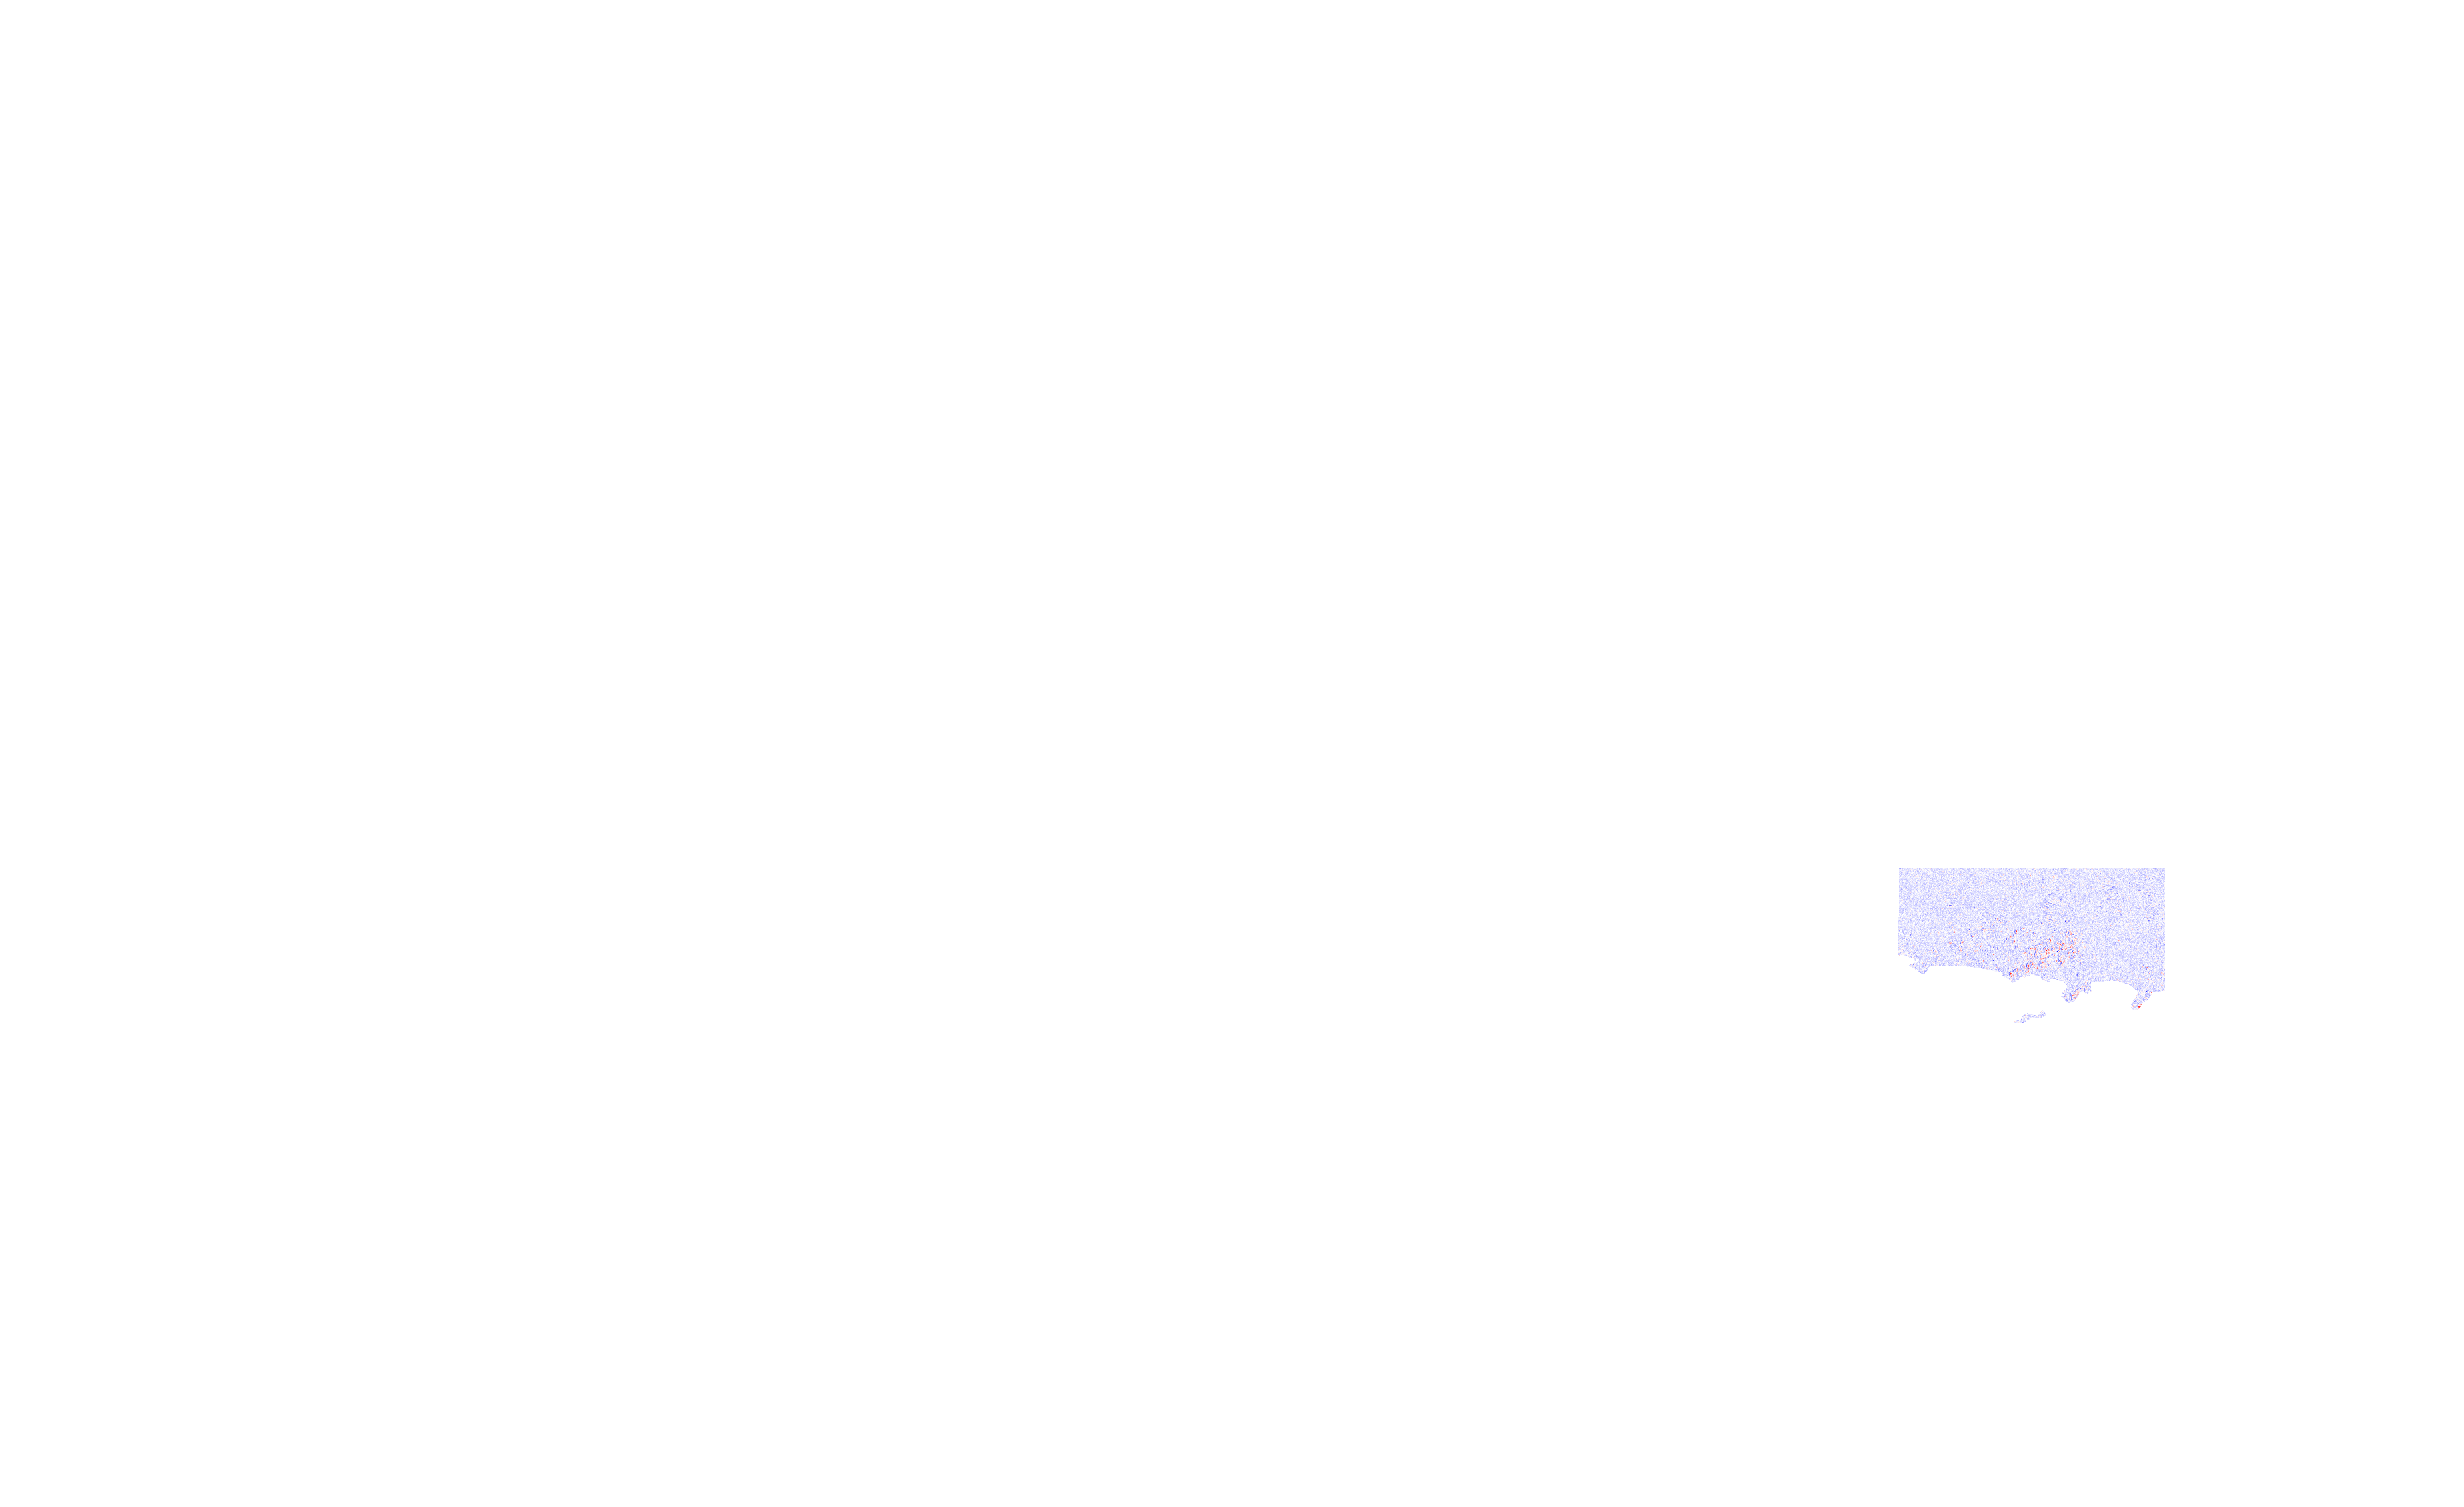

In [20]:
# Set bounds for visualization
minlon,minlat,maxlon,maxlat = transform_bounds(src_crs, CRS.from_epsg(4326), *img_bounds)
new_bbox = [minlon, maxlon, minlat, maxlat]

# Colorize the array for plotting in folium
src1 = colorize(np.squeeze(vv_img_transformed)*dem_array, 'bwr', -5, 5)
src2 = colorize(np.squeeze(vh_img_transformed)*dem_array, 'bwr', -7, 9)

# Overlay merged bursts onto a basemap.
# Initialize Folium basemap and define center of mapview
xmid =(new_bbox[0]+new_bbox[1])/2 ; ymid = (new_bbox[2]+new_bbox[3])/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Include mosaics as layers
# Colorized backscatter
folium.raster_layers.ImageOverlay(src1, 
                                        opacity=.9, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='VV backscatter (dB)',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(src2, 
                                        opacity=.9, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='VH backscatter (dB)',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=150, height=150)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

m